In [3]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
# import s3fs
# import fastparquet
# import awswrangler as wr
import os

# import pyarrow.parquet as pq
# import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [4]:
returns = pd.read_csv('ibex_historical_returns.csv',index_col='date')
returns.index = pd.to_datetime(returns.index)
returns.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-11,NaN,NaN,NaN,NaN,NaN,0.038238,NaN,NaN,NaN,-0.001007,...,NaN,NaN,NaN,NaN,0.005841,NaN,NaN,NaN,NaN,0.009776
1993-08-12,NaN,NaN,NaN,NaN,NaN,0.039881,NaN,NaN,NaN,0.024588,...,NaN,NaN,NaN,NaN,0.022995,NaN,NaN,NaN,NaN,0.017845
1993-08-13,NaN,NaN,NaN,NaN,NaN,0.017449,NaN,NaN,NaN,0.030090,...,NaN,NaN,NaN,NaN,0.002876,NaN,NaN,NaN,NaN,0.008291
1993-08-16,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.001881,...,NaN,NaN,NaN,NaN,0.002733,NaN,NaN,NaN,NaN,0.000385
1993-08-17,NaN,NaN,NaN,NaN,NaN,0.000831,NaN,NaN,NaN,0.023395,...,NaN,NaN,NaN,NaN,0.025183,NaN,NaN,NaN,NaN,0.016909


In [5]:
prices = pd.read_csv('ibex_historical_data.csv',index_col='date')
prices.index = pd.to_datetime(prices.index)
prices

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-10,NaN,NaN,NaN,NaN,NaN,1.0929,NaN,NaN,NaN,3.2773,...,NaN,NaN,NaN,NaN,2.8678,NaN,NaN,NaN,NaN,3002.896973
1993-08-11,NaN,NaN,NaN,NaN,NaN,1.1355,NaN,NaN,NaN,3.2740,...,NaN,NaN,NaN,NaN,2.8846,NaN,NaN,NaN,NaN,3032.396729
1993-08-12,NaN,NaN,NaN,NaN,NaN,1.1817,NaN,NaN,NaN,3.3555,...,NaN,NaN,NaN,NaN,2.9517,NaN,NaN,NaN,NaN,3086.996826
1993-08-13,NaN,NaN,NaN,NaN,NaN,1.2025,NaN,NaN,NaN,3.4580,...,NaN,NaN,NaN,NaN,2.9602,NaN,NaN,NaN,NaN,3112.696777
1993-08-16,NaN,NaN,NaN,NaN,NaN,1.2025,NaN,NaN,NaN,3.4515,...,NaN,NaN,NaN,NaN,2.9683,NaN,NaN,NaN,NaN,3113.896729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,NaN,NaN,NaN,NaN,31.36,NaN,9.320,145.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9368.400391
2023-08-07,NaN,NaN,NaN,NaN,31.44,NaN,9.338,144.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9358.599609
2023-08-08,NaN,NaN,NaN,NaN,31.39,NaN,9.254,145.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9301.799805


In [6]:
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-07-25,5.436,5.432,5.439,5.426,0.34%
2023-07-24,5.418,5.453,5.486,5.418,-0.11%
2023-07-21,5.424,5.445,5.469,5.411,0.15%
2023-07-20,5.416,5.448,5.503,5.409,0.07%
2023-07-19,5.412,5.452,5.452,5.409,0.00%


In [ ]:
def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col
locate_in_df(sharpe_ratio,sharpe_ratio.min().min()),sharpe_ratio.min().min()

NameError: name 'sharpe_ratio' is not defined

In [7]:
# DEFINIMOS UNA CANTIDAD DE DIAS PARA LA VENTANA DE CALCULO DE LOS RETORNOS
DIAS = 90
ACTIVOS = 10

returns_cleaned = returns.apply(lambda x: x.fillna(abs(x.min())*-2), axis=1)
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns_cleaned['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
returns_cleaned['risk_free_rate'] = returns_cleaned['risk_free_rate'].fillna(method='ffill')
# AGREGAMOS LA OPCIÓN DE NO INVERTIR EN NINGUN ACTIVO COMO UNA COLUMNA CON RETORNO CERO
# returns['cash'] = 0

In [8]:
# CALCULAMOS LA SUMA DE RETORNOS CON ESA VENTANA DE DIAS DEFINIDA
adjusted_returns = (returns_cleaned.iloc[:,:-2].T - returns_cleaned['risk_free_rate']).T
adjusted_period_returns_mean = adjusted_returns.rolling(DIAS, min_periods=DIAS).mean()
adjusted_period_returns_std = adjusted_returns.rolling(DIAS, min_periods=DIAS).std()
downside_dev  = np.minimum(0, adjusted_returns)**2
downside_dev = np.sqrt(downside_dev.rolling(DIAS,min_periods=DIAS).mean())
benchmark_std = returns['benchmark'].rolling(DIAS,min_periods=DIAS).std()

market_stock_cov = returns_cleaned.iloc[:,:-2].rolling(DIAS, min_periods=DIAS).cov(returns_cleaned.iloc[:,-2])
market_variance = returns_cleaned.iloc[:,-2].rolling(DIAS, min_periods=DIAS).var()
beta = (market_stock_cov.T/market_variance).T
treynor_ratio = adjusted_period_returns_mean / beta

benchmark_adjusted_returns = (returns_cleaned.iloc[:,:-2].T - returns_cleaned['benchmark']).T
benchmark_adjusted_returns_mean = benchmark_adjusted_returns.rolling(DIAS, min_periods=DIAS).mean()
benchmark_adjusted_returns_std = benchmark_adjusted_returns.rolling(DIAS, min_periods=DIAS).std()

sharpe_ratio = adjusted_period_returns_mean / adjusted_period_returns_std
sortino_ratio =  adjusted_period_returns_mean / downside_dev
modigliani_measure = ((sharpe_ratio.T * benchmark_std) + returns_cleaned['risk_free_rate']).T
information_ratio = benchmark_adjusted_returns_mean / benchmark_adjusted_returns_std
# alfa_jensen = returns_cleaned.iloc[:,:-2].T - (returns_cleaned['risk_free_rate'] - beta * (returns_cleaned['benchmark'] - returns_cleaned['risk_free_rate']))

In [9]:
rolling_max = prices.iloc[:, :-1].expanding(min_periods=DIAS).max()
daily_drawdown = (prices.iloc[:, :-1] / rolling_max) - 1.0
max_drawdown = daily_drawdown.rolling(DIAS, min_periods=DIAS).min()
calmar_ratio = adjusted_period_returns_mean / max_drawdown

In [ ]:
returns_cleaned.iloc[:,:-2].T - (returns_cleaned['risk_free_rate'] - beta * (returns_cleaned['benchmark'] - returns_cleaned['risk_free_rate']))

MemoryError: Unable to allocate 446. MiB for an array with shape (7603, 7697) and data type float64

In [10]:
ranking_sharpe = sharpe_ratio[DIAS-1:][:-2].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_sortino = sortino_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_modigliani = modigliani_measure[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_treynor = treynor_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_information = information_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_calmar = calmar_ratio[DIAS-1:].dropna(how='all').rank(axis=1, numeric_only=True, method='max',ascending=False)

In [11]:
ranking_concat = pd.concat([ranking_sharpe,ranking_sortino,ranking_modigliani,ranking_treynor, ranking_information,ranking_calmar])
ranking_concat = np.round(ranking_concat.groupby(ranking_concat.index).mean(),0)
ranking_concat

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-17,93.0,93.0,93.0,93.0,93.0,25.0,93.0,93.0,93.0,23.0,...,93.0,93.0,93.0,93.0,93.0,3.0,93.0,93.0,93.0,93.0
1993-12-20,93.0,93.0,93.0,93.0,93.0,26.0,93.0,93.0,93.0,23.0,...,93.0,93.0,93.0,93.0,93.0,3.0,93.0,93.0,93.0,93.0
1993-12-21,93.0,93.0,93.0,93.0,93.0,26.0,93.0,93.0,93.0,25.0,...,93.0,93.0,93.0,93.0,93.0,3.0,93.0,93.0,93.0,93.0
1993-12-22,93.0,93.0,93.0,93.0,93.0,26.0,93.0,93.0,93.0,25.0,...,93.0,93.0,93.0,93.0,93.0,3.0,93.0,93.0,93.0,93.0
1993-12-23,93.0,93.0,93.0,93.0,93.0,26.0,93.0,93.0,93.0,23.0,...,93.0,93.0,93.0,93.0,93.0,3.0,93.0,93.0,93.0,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,55.0,60.0,54.0,32.0,61.0,48.0,59.0,60.0,52.0,54.0,...,61.0,53.0,42.0,54.0,58.0,54.0,59.0,51.0,43.0,64.0
2023-08-07,46.0,52.0,47.0,32.0,62.0,48.0,58.0,61.0,44.0,54.0,...,63.0,47.0,36.0,54.0,49.0,54.0,59.0,43.0,43.0,65.0
2023-08-08,54.0,60.0,53.0,24.0,62.0,42.0,58.0,60.0,51.0,47.0,...,57.0,45.0,34.0,47.0,57.0,47.0,52.0,50.0,36.0,58.0


In [12]:
# ranking = sharpe_ratio.loc[sharpe_ratio.index[DIAS:]].rank(axis=1, numeric_only=True, method='max',ascending=False)
# ranking = (sharpe_ratio.loc[sharpe_ratio.index[10:-4]] - sharpe_ratio.loc[sharpe_ratio.index[10:-4]].mean())/sharpe_ratio.loc[sharpe_ratio.index[10:-4]].std()
# ranking = sharpe_ratio.loc[sharpe_ratio.index[DIAS:]]#.fillna(sharpe_ratio.min().min())
# ranking = ((ranking - ranking.mean()) / ranking.std())
ranking = (ranking_concat - ranking_concat.min())/(ranking_concat.max() - ranking_concat.min())
# ranking = ranking.fillna(-1)
ranking

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-17,0.989247,0.988636,0.988506,0.988764,0.989011,0.289157,0.989130,0.989130,0.988095,0.233333,...,0.988636,0.989011,0.988636,0.989130,0.988889,0.0250,0.989130,0.988636,0.988636,0.989130
1993-12-20,0.989247,0.988636,0.988506,0.988764,0.989011,0.301205,0.989130,0.989130,0.988095,0.233333,...,0.988636,0.989011,0.988636,0.989130,0.988889,0.0250,0.989130,0.988636,0.988636,0.989130
1993-12-21,0.989247,0.988636,0.988506,0.988764,0.989011,0.301205,0.989130,0.989130,0.988095,0.255556,...,0.988636,0.989011,0.988636,0.989130,0.988889,0.0250,0.989130,0.988636,0.988636,0.989130
1993-12-22,0.989247,0.988636,0.988506,0.988764,0.989011,0.301205,0.989130,0.989130,0.988095,0.255556,...,0.988636,0.989011,0.988636,0.989130,0.988889,0.0250,0.989130,0.988636,0.988636,0.989130
1993-12-23,0.989247,0.988636,0.988506,0.988764,0.989011,0.301205,0.989130,0.989130,0.988095,0.233333,...,0.988636,0.989011,0.988636,0.989130,0.988889,0.0250,0.989130,0.988636,0.988636,0.989130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,0.580645,0.613636,0.540230,0.303371,0.637363,0.566265,0.619565,0.630435,0.500000,0.577778,...,0.625000,0.549451,0.409091,0.565217,0.600000,0.6625,0.619565,0.511364,0.420455,0.673913
2023-08-07,0.483871,0.522727,0.459770,0.303371,0.648352,0.566265,0.608696,0.641304,0.404762,0.577778,...,0.647727,0.483516,0.340909,0.565217,0.500000,0.6625,0.619565,0.420455,0.420455,0.684783
2023-08-08,0.569892,0.613636,0.528736,0.213483,0.648352,0.493976,0.608696,0.630435,0.488095,0.500000,...,0.579545,0.461538,0.318182,0.489130,0.588889,0.5750,0.543478,0.500000,0.340909,0.608696


In [13]:
ranking = ranking.dropna()

In [275]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.models import Sequential
import tensorflow_ranking as tfr
from keras.callbacks import EarlyStopping

In [276]:
rolling_std = adjusted_returns.rolling(5, min_periods=5).std()[4:]
rolling_std

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,0.057262,0.057262,0.057262,0.057262,0.057262,0.019350,0.057262,0.057262,0.057262,0.015221,...,0.057262,0.057262,0.057262,0.057262,0.057262,0.011243,0.057262,0.057262,0.057262,0.057262
1993-08-18,0.056361,0.056361,0.056361,0.056361,0.056361,0.017750,0.056361,0.056361,0.056361,0.013979,...,0.056361,0.056361,0.056361,0.056361,0.056361,0.012412,0.056361,0.056361,0.056361,0.056361
1993-08-19,0.054026,0.054026,0.054026,0.054026,0.054026,0.008410,0.054026,0.054026,0.054026,0.016719,...,0.054026,0.054026,0.054026,0.054026,0.054026,0.019855,0.054026,0.054026,0.054026,0.054026
1993-08-20,0.051283,0.051283,0.051283,0.051283,0.051283,0.003036,0.051283,0.051283,0.051283,0.012850,...,0.051283,0.051283,0.051283,0.051283,0.051283,0.020615,0.051283,0.051283,0.051283,0.051283
1993-08-23,0.019354,0.019354,0.019354,0.019354,0.019354,0.002756,0.019354,0.019354,0.019354,0.018673,...,0.019354,0.019354,0.019354,0.019354,0.019354,0.020742,0.019354,0.019354,0.019354,0.019354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,0.044642,0.044642,0.044642,0.044642,0.006061,0.044642,0.008332,0.007696,0.044642,0.044642,...,0.044642,0.044642,0.044642,0.044642,0.044642,0.044642,0.044642,0.044642,0.044642,0.044642
2023-08-07,0.047217,0.047217,0.047217,0.047217,0.006594,0.047217,0.007038,0.007481,0.047217,0.047217,...,0.047217,0.047217,0.047217,0.047217,0.047217,0.047217,0.047217,0.047217,0.047217,0.047217
2023-08-08,0.047433,0.047433,0.047433,0.047433,0.006442,0.047433,0.006819,0.005943,0.047433,0.047433,...,0.047433,0.047433,0.047433,0.047433,0.047433,0.047433,0.047433,0.047433,0.047433,0.047433


In [277]:
test = pd.concat([rolling_std,returns_cleaned.loc[rolling_std.index[0]:].iloc[:,:-2]], axis=1).dropna(how='all')

In [278]:
test_2 = []
for i in range(test.shape[0]-DIAS):
    a = test.iloc[i,:94]
    b = test.iloc[i,94:]
    c = pd.concat([a,b],axis=1)
    c.columns = ['returns','std']
    test_2.append(c)
test_2  = np.array(test_2)
test_2.shape

In [279]:
test_2  = np.array(test_2)
test_2.shape

(7509, 94, 2)

In [281]:
test_split = math.floor(test_2.shape[0]*0.7)
val_split = math.floor(test_2.shape[0]*0.9)
metricas = 2
# X = treynor_ratio.iloc[DIAS-1:]#.fillna(returns.min().min() * 2,)

data = np.zeros((test_2.shape[0], 90, test_2.shape[1], 2))

for i in range(test_2.shape[0]-DIAS):
    data[i] = test_2[i:i+DIAS]

In [282]:
data.shape

(7509, 90, 94, 2)

In [283]:
window = 30

In [240]:
data_ranking = np.zeros((ranking.shape[0],window,ranking.shape[1]))
for i in range(ranking.shape[0]-window):
    data_ranking[i] = ranking[i:i+window]

In [241]:
# ranking = tf.keras.utils.to_categorical(ranking-1, num_classes = len(ranking.columns))

In [284]:
ranking.shape, data.shape

((7514, 94), (7509, 90, 94, 2))

In [457]:
X_train = data[:test_split-window]
X_test = data[test_split:val_split-window-5]
X_val = data[val_split-5:-window-300]
X_val2 = data[-window-300:-window]
y_train = ranking[window:test_split]
y_test = ranking[test_split+window+5:val_split]
y_val = ranking[val_split+window:-300]
y_val2 = ranking[-300:]

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(X_val2.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)
print(y_val2.shape)

(5226, 90, 94, 2)
(1467, 90, 94, 2)
(426, 90, 94, 2)
(300, 90, 94, 2)
(5226, 94)
(1467, 94)
(426, 94)
(300, 94)


In [458]:
from keras import backend as K
hp_top = 10
hp_incremento_top = 5
def top_is_target(y_true, y_pred):
  num_samples = K.shape(y_true)[0]

  w = K.arange(94, dtype='float32')
  w = K.reverse(w, axes=0) + 0.0001

  w = tf.where(K.arange(94) < hp_top, w * hp_incremento_top, w)
  # Replicar w a lo largo del eje 0 (batch)
  #w = K.repeat_elements(K.expand_dims(w, 0), num_samples, axis=0)
  w = tf.tile(K.expand_dims(w, 0), [num_samples, 1])

  # Calcular la pérdida
  r = K.cast(y_true, 'float32')
  r_pred = K.cast(y_pred, 'float32')

  return K.mean(w * K.square(r - r_pred), axis=-1)

In [459]:
model = Sequential()

model.add(Conv1D(6, 3, activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3],), kernel_regularizer=L2(0.2)))
model.add(Dropout(0.5))
model.add(Conv1D(3, 3, activation='tanh', kernel_regularizer=L2(0.2)))
model.add(Dropout(0.5))
# model.add(Dense(32,activation='relu',kernel_regularizer=L2(0.002)))
# model.add(Dropout(0.5))
# model.add(Dense(16,activation='relu',kernel_regularizer=L2(0.002)))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(data.shape[2],activation='tanh'))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 90, 92, 6)         42        
                                                                 
 dropout_12 (Dropout)        (None, 90, 92, 6)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 90, 90, 3)         57        
                                                                 
 dropout_13 (Dropout)        (None, 90, 90, 3)         0         
                                                                 
 flatten_6 (Flatten)         (None, 24300)             0         
                                                                 
 dense_16 (Dense)            (None, 94)                2284294   
                                                                 
Total params: 2284393 (8.71 MB)
Trainable params: 2284

In [460]:
model = Sequential()

model.add(Dense(6, activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3],), kernel_regularizer=L2(0.5)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='tanh', kernel_regularizer=L2(0.5)))
model.add(Dropout(0.5))
# model.add(Dense(32,activation='relu',kernel_regularizer=L2(0.002)))
# model.add(Dropout(0.5))
# model.add(Dense(16,activation='relu',kernel_regularizer=L2(0.002)))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(data.shape[2],activation='tanh'))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 90, 94, 6)         18        
                                                                 
 dropout_14 (Dropout)        (None, 90, 94, 6)         0         
                                                                 
 dense_18 (Dense)            (None, 90, 94, 3)         21        
                                                                 
 dropout_15 (Dropout)        (None, 90, 94, 3)         0         
                                                                 
 flatten_7 (Flatten)         (None, 25380)             0         
                                                                 
 dense_19 (Dense)            (None, 94)                2385814   
                                                                 
Total params: 2385853 (9.10 MB)
Trainable params: 2385

In [461]:
earlystopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

In [462]:
batch_size = 32
h = model.fit(
      X_train, y_train,
      epochs=len(X_train) // batch_size + 1,
      validation_data = (X_test, y_test),
      callbacks = [earlystopping],
      shuffle=False,
      verbose=True
          )

Epoch 1/164
164/164 [==============================] - 12s 68ms/step - loss: 3.0627 - val_loss: 2.3245
Epoch 2/164
164/164 [==============================] - 8s 51ms/step - loss: 1.7115 - val_loss: 1.3092
Epoch 3/164
164/164 [==============================] - 8s 52ms/step - loss: 0.9264 - val_loss: 0.7394
Epoch 4/164
164/164 [==============================] - 9s 52ms/step - loss: 0.5176 - val_loss: 0.4376
Epoch 5/164
164/164 [==============================] - 9s 53ms/step - loss: 0.3388 - val_loss: 0.2860
Epoch 6/164
164/164 [==============================] - 9s 53ms/step - loss: 0.2376 - val_loss: 0.2312
Epoch 7/164
164/164 [==============================] - 9s 53ms/step - loss: 0.2272 - val_loss: 0.2013
Epoch 8/164
164/164 [==============================] - 8s 51ms/step - loss: 0.1834 - val_loss: 0.1931
Epoch 9/164
164/164 [==============================] - 9s 52ms/step - loss: 0.1876 - val_loss: 0.1918
Epoch 10/164
164/164 [==============================] - 9s 53ms/step - loss: 0.16

KeyboardInterrupt: 

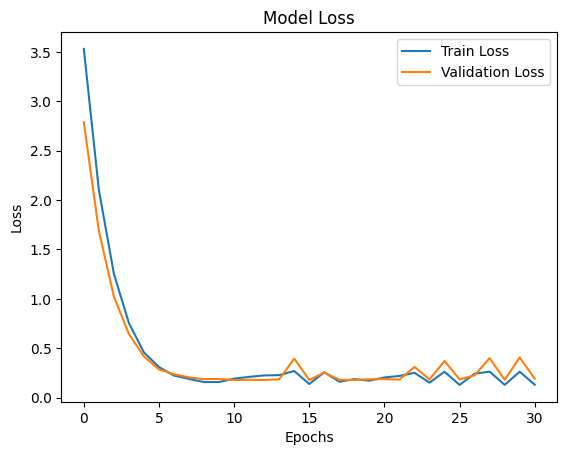

In [ ]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# y_pred = model.evaluate(X_val, y_val)
# y_pred

In [464]:
y_pred = model.predict(X_val)
y_pred

14/14 [==============================] - 0s 7ms/step


array([[0.99993837, 0.9984067 , 0.99301094, ..., 0.9835851 , 0.999749  ,
        0.99945176],
       [0.9999383 , 0.9984067 , 0.9930111 , ..., 0.9835851 , 0.99974895,
        0.99945164],
       [0.99993837, 0.9984068 , 0.99301106, ..., 0.98358536, 0.999749  ,
        0.99945164],
       ...,
       [0.99993837, 0.9984068 , 0.99301076, ..., 0.9835853 , 0.999749  ,
        0.99945146],
       [0.99993837, 0.9984068 , 0.9930109 , ..., 0.9835854 , 0.9997491 ,
        0.9994516 ],
       [0.99993837, 0.9984068 , 0.99301076, ..., 0.9835852 , 0.9997491 ,
        0.99945164]], dtype=float32)

In [465]:
index = val_split
indexes = list(returns_cleaned.iloc[index:].iloc[:,:-2])

In [466]:
y_pred = pd.DataFrame(y_pred, columns=returns_cleaned.iloc[:,:-2].columns)[indexes]
y_pred

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
0,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999887,0.999314,0.967970,0.809913,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
1,0.999938,0.998407,0.993011,0.999995,0.999225,0.799577,0.999887,0.999314,0.967970,0.809914,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
2,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999887,0.999314,0.967970,0.809915,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
3,0.999938,0.998407,0.993011,0.999995,0.999225,0.799577,0.999887,0.999314,0.967970,0.809915,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
4,0.999938,0.998407,0.993011,0.999995,0.999225,0.799577,0.999887,0.999314,0.967970,0.809915,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.999938,0.998407,0.993011,0.999995,0.999225,0.799576,0.999887,0.999314,0.967969,0.809909,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
422,0.999938,0.998407,0.993011,0.999995,0.999225,0.799577,0.999887,0.999314,0.967969,0.809911,...,0.999777,0.999507,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999451
423,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999886,0.999314,0.967969,0.809909,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999451
424,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999887,0.999314,0.967969,0.809911,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452


In [467]:
error_total = pd.DataFrame()
in_index = []
for i in range(y_val.shape[0]):
    index = y_val.iloc[i].name
    indexes = list(returns.loc[index].dropna().index[:-2])
    ranking_real = np.argsort(np.argsort(-y_val.iloc[i][indexes]))
    ranking_pred = np.argsort(np.argsort(-y_pred.iloc[i][indexes]))

    ranking_real_ordenado = ranking_real.iloc[np.where(ranking_real<10)].index
    ranking_pred_ordenado = ranking_pred.iloc[np.where(ranking_pred<10)] .index   


    int_real_pred = len(set(ranking_real_ordenado).intersection(set(ranking_pred_ordenado)))

    error = abs(ranking_real - ranking_pred)
    # error_top = error[ranking_pred_ordenado.index]
    error_total = pd.concat([error_total,error], axis=1)
    in_index.append(int_real_pred)

In [468]:
error_total.columns = y_val.index

In [469]:
error_total

date,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,...,2022-05-30,2022-05-31,2022-06-01,2022-06-02,2022-06-03,2022-06-06,2022-06-07,2022-06-08,2022-06-09,2022-06-10
ACS,6.0,6.0,5.0,5.0,5.0,3.0,5.0,6.0,5.0,4.0,...,3.0,5.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
ACX_2,15.0,16.0,15.0,19.0,20.0,22.0,21.0,18.0,20.0,23.0,...,19.0,23.0,23.0,22.0,21.0,22.0,21.0,21.0,21.0,23.0
AENA,2.0,0.0,1.0,4.0,2.0,5.0,3.0,5.0,8.0,3.0,...,11.0,12.0,12.0,13.0,13.0,12.0,12.0,12.0,13.0,8.0
ALM,6.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,...,10.0,7.0,8.0,9.0,10.0,6.0,6.0,9.0,7.0,8.0
AMS_1,7.0,5.0,6.0,3.0,4.0,4.0,4.0,6.0,2.0,2.0,...,4.0,8.0,8.0,3.0,6.0,5.0,5.0,5.0,9.0,6.0
ANA_2,11.0,8.0,11.0,12.0,11.0,10.0,10.0,9.0,12.0,13.0,...,8.0,6.0,5.0,6.0,6.0,6.0,6.0,6.0,8.0,7.0
BBVA,15.0,17.0,16.0,16.0,12.0,13.0,12.0,11.0,12.0,12.0,...,19.0,17.0,14.0,18.0,17.0,16.0,17.0,16.0,21.0,22.0
BKIA_1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BKT,27.0,27.0,27.0,26.0,25.0,28.0,28.0,28.0,28.0,28.0,...,8.0,10.0,14.0,13.0,12.0,13.0,13.0,13.0,15.0,12.0
CABK,14.0,12.0,13.0,12.0,14.0,14.0,15.0,12.0,13.0,14.0,...,0.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0


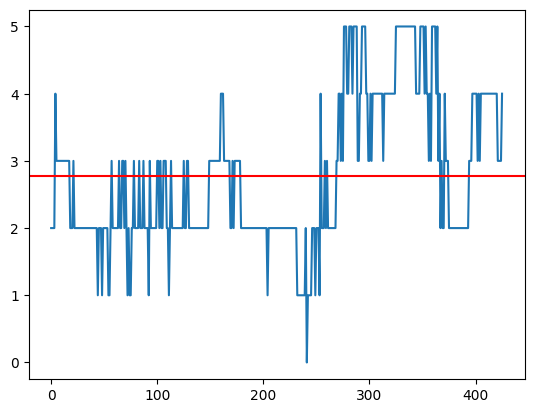

In [470]:
plt.plot(range(y_val.shape[0]), in_index)
plt.axhline(xmin=0,xmax=y_val.shape[0], y=np.mean(in_index),c='red');

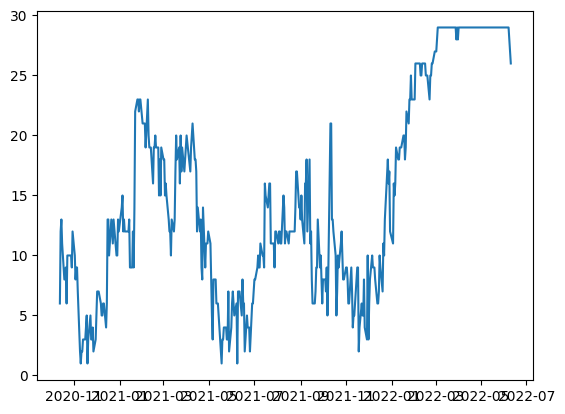

In [471]:
plt.plot(error_total.loc['ITX']);

In [472]:
error_total.mean(axis=1)[(error_total.mean(axis=1)<5)],error_total.std(axis=1)[(error_total.mean(axis=1)<5)]

(BKIA_1    4.076923
 dtype: float64,
 BKIA_1    3.516351
 dtype: float64)

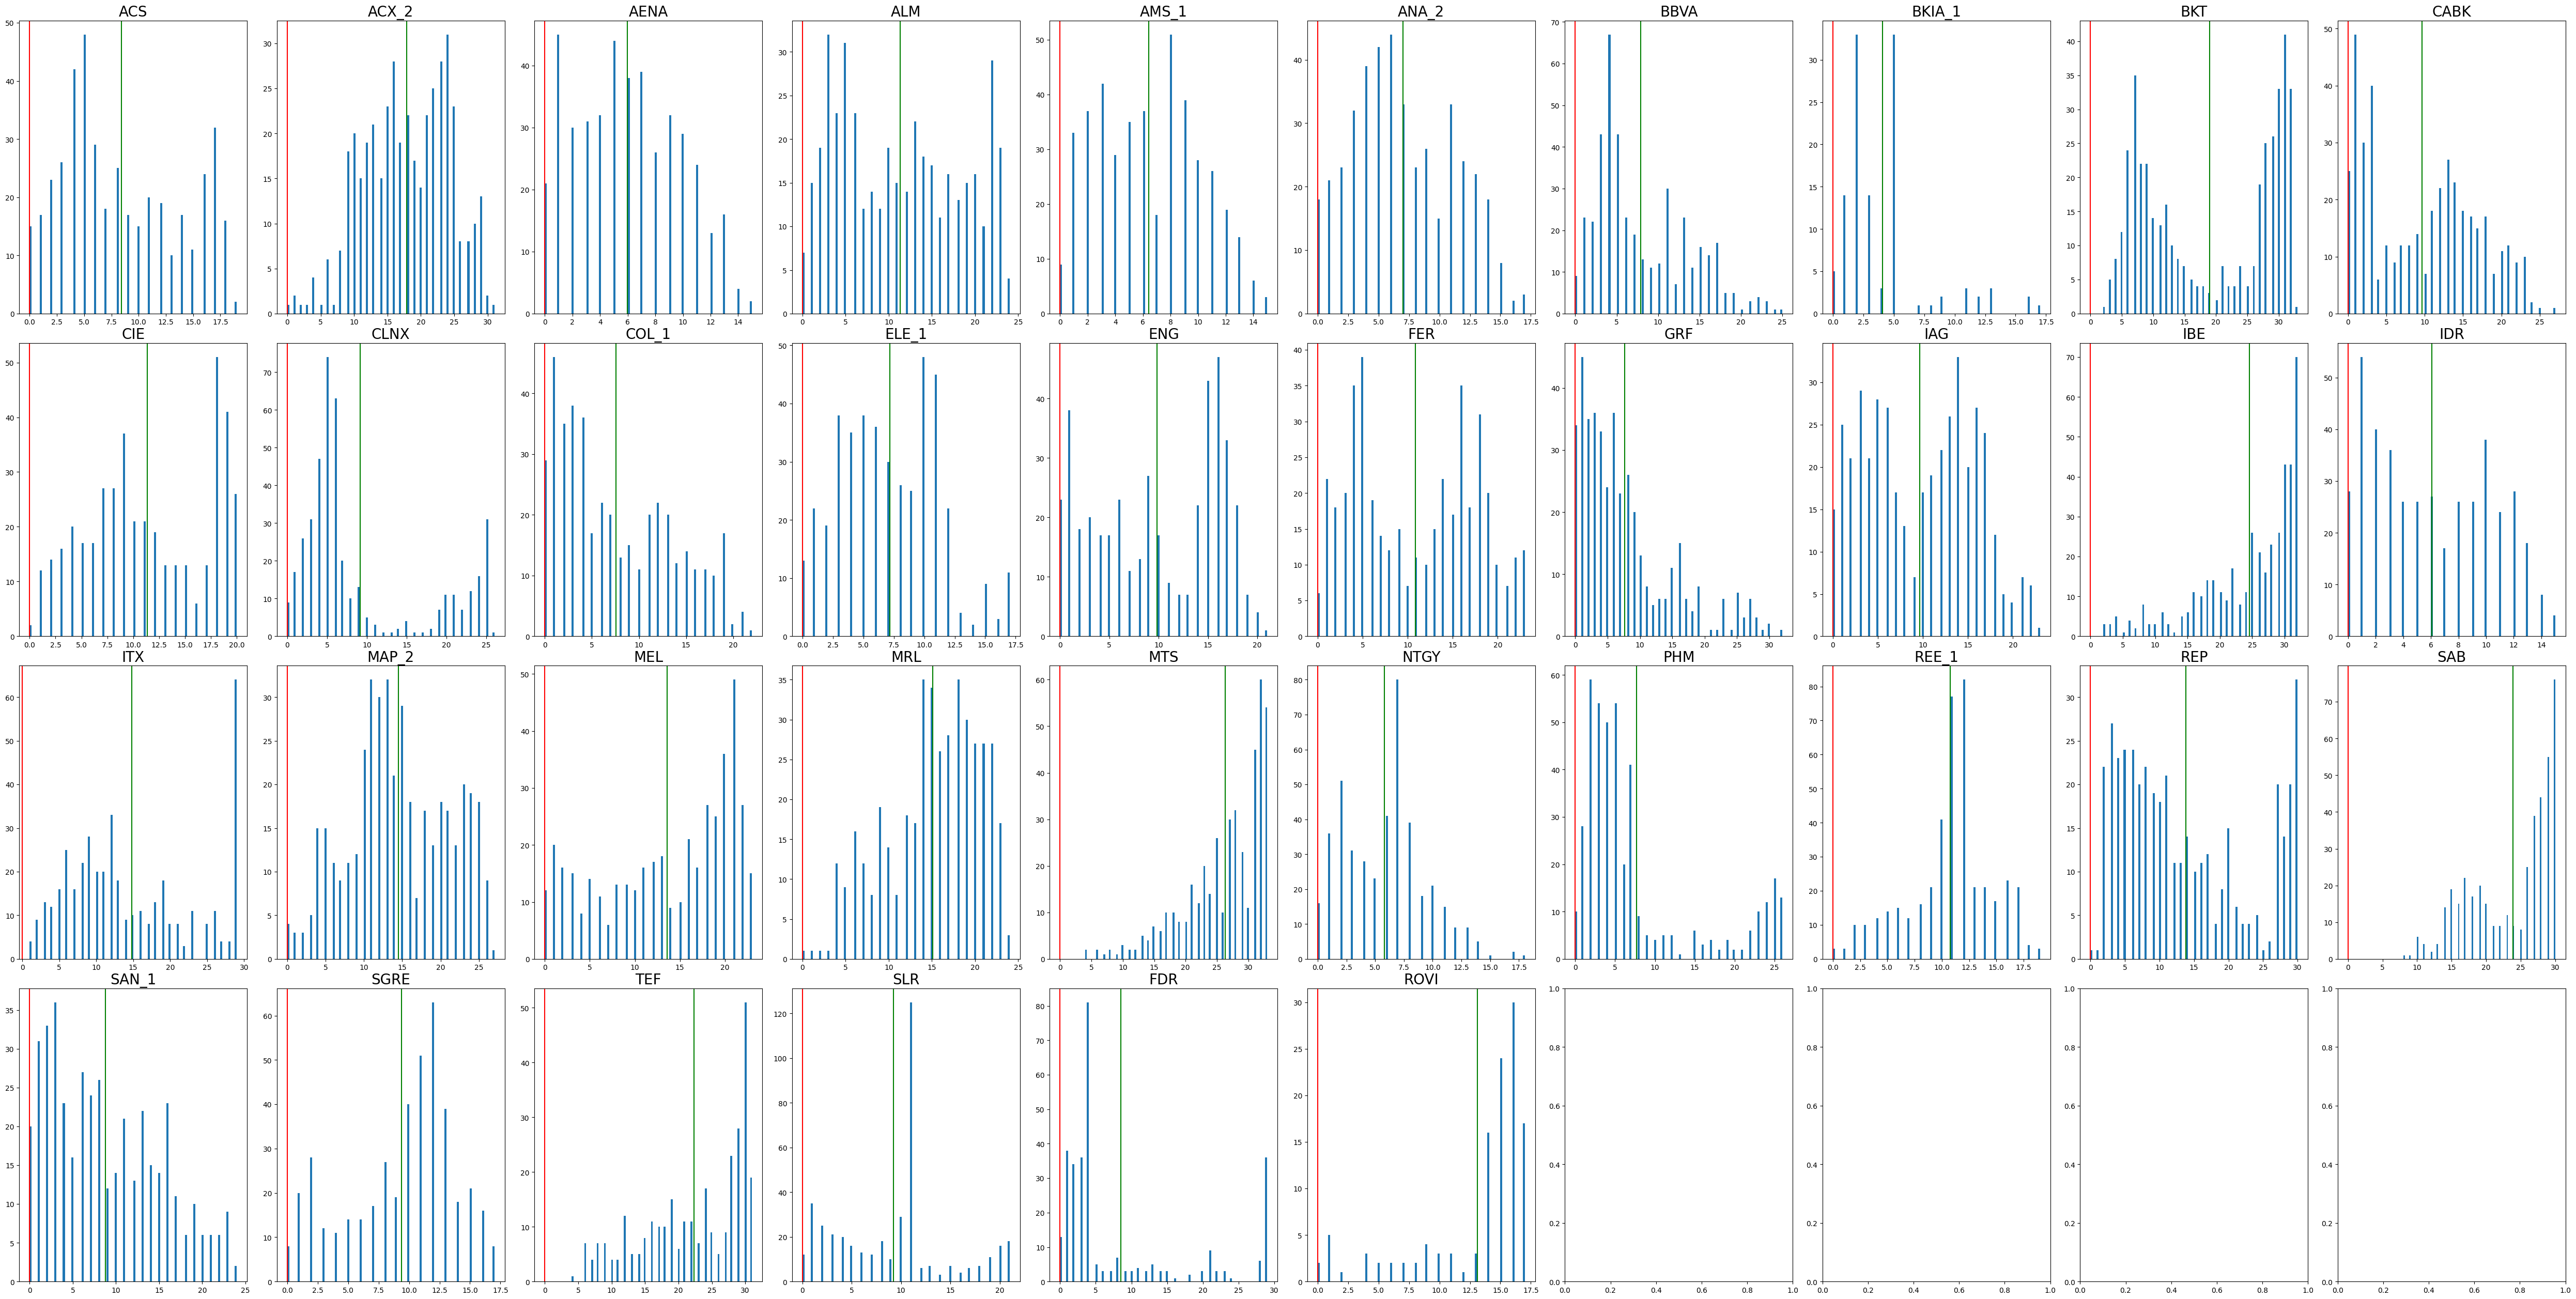

In [473]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=math.ceil(len(error_total.index)/10), ncols=10, figsize=(50, 25))
fig.tight_layout(h_pad=2)
axs = axs.ravel()

for i in range(len(error_total.index)):

    axs[i].hist(error_total.loc[error_total.index[i]].dropna(),bins=100)
    axs[i].axvline(x=0,ymin=0,ymax=error_total.loc[error_total.index[i]].dropna().max()+1,c='red')
    axs[i].axvline(x=error_total.loc[error_total.index[i]].dropna().mean(),ymin=0,ymax=error_total.loc[error_total.index[i]].dropna().max()+1,c='green')
    axs[i].set_title(error_total.index[i],fontsize=20)

In [474]:
y_pred = model.predict(X_val2)
y_pred

10/10 [==============================] - 0s 7ms/step


array([[0.99993837, 0.99840677, 0.99301076, ..., 0.983585  , 0.9997489 ,
        0.9994516 ],
       [0.9999383 , 0.9984069 , 0.99301076, ..., 0.9835853 , 0.99974895,
        0.99945176],
       [0.99993837, 0.99840677, 0.9930108 , ..., 0.9835852 , 0.99974895,
        0.99945164],
       ...,
       [0.9999382 , 0.99840635, 0.9930049 , ..., 0.98357636, 0.9997487 ,
        0.99945104],
       [0.9999382 , 0.99840635, 0.9930049 , ..., 0.98357636, 0.9997487 ,
        0.99945104],
       [0.9999382 , 0.99840635, 0.9930049 , ..., 0.98357636, 0.9997487 ,
        0.99945104]], dtype=float32)

In [475]:
index = val_split
indexes = list(returns_cleaned.iloc[index:].iloc[:,:-2])

In [476]:
y_pred = pd.DataFrame(y_pred, columns=returns_cleaned.iloc[:,:-2].columns)[indexes]
y_pred

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
0,0.999938,0.998407,0.993011,0.999995,0.999225,0.799577,0.999887,0.999314,0.967969,0.809909,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
1,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999886,0.999314,0.967969,0.809910,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
2,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999887,0.999314,0.967969,0.809911,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999452
3,0.999938,0.998407,0.993011,0.999995,0.999225,0.799578,0.999886,0.999314,0.967969,0.809911,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983585,0.999749,0.999451
4,0.999938,0.998407,0.993011,0.999995,0.999225,0.799580,0.999887,0.999314,0.967970,0.809913,...,0.999777,0.999508,0.999855,0.997657,0.993654,0.998651,0.997961,0.983586,0.999749,0.999452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.999938,0.998406,0.993005,0.999995,0.999225,0.799534,0.999887,0.999313,0.967948,0.809779,...,0.999776,0.999508,0.999855,0.997655,0.993648,0.998649,0.997959,0.983576,0.999749,0.999451
296,0.999938,0.998406,0.993005,0.999995,0.999225,0.799534,0.999887,0.999313,0.967948,0.809779,...,0.999776,0.999508,0.999855,0.997655,0.993648,0.998649,0.997959,0.983576,0.999749,0.999451
297,0.999938,0.998406,0.993005,0.999995,0.999225,0.799534,0.999887,0.999313,0.967948,0.809779,...,0.999776,0.999508,0.999855,0.997655,0.993648,0.998649,0.997959,0.983576,0.999749,0.999451
298,0.999938,0.998406,0.993005,0.999995,0.999225,0.799534,0.999887,0.999313,0.967948,0.809779,...,0.999776,0.999508,0.999855,0.997655,0.993648,0.998649,0.997959,0.983576,0.999749,0.999451


In [477]:
error_total = pd.DataFrame()
in_index = []
for i in range(y_val2.shape[0]):
    index = y_val2.iloc[i].name
    indexes = list(returns.loc[index].dropna().index[:-2])
    ranking_real = np.argsort(np.argsort(-y_val2.iloc[i][indexes]))
    ranking_pred = np.argsort(np.argsort(-y_pred.iloc[i][indexes]))

    ranking_real_ordenado = ranking_real.iloc[np.where(ranking_real<10)].index
    ranking_pred_ordenado = ranking_pred.iloc[np.where(ranking_pred<10)] .index   


    int_real_pred = len(set(ranking_real_ordenado).intersection(set(ranking_pred_ordenado)))

    error = abs(ranking_real - ranking_pred)
    # error_top = error[ranking_pred_ordenado.index]
    error_total = pd.concat([error_total,error], axis=1)
    in_index.append(int_real_pred)

In [478]:
error_total.columns = y_val2.index

In [479]:
error_total

date,2022-06-13,2022-06-14,2022-06-15,2022-06-16,2022-06-17,2022-06-20,2022-06-21,2022-06-22,2022-06-23,2022-06-24,...,2023-07-28,2023-07-31,2023-08-01,2023-08-02,2023-08-03,2023-08-04,2023-08-07,2023-08-08,2023-08-09,2023-08-10
ACS,5.0,6.0,5.0,7.0,6.0,6.0,4.0,5.0,5.0,7.0,...,8.0,10.0,10.0,10.0,8.0,10.0,9.0,9.0,6.0,NaN
ACX_2,19.0,20.0,18.0,17.0,15.0,17.0,18.0,17.0,17.0,15.0,...,13.0,13.0,13.0,14.0,13.0,12.0,14.0,13.0,12.0,NaN
AENA,9.0,11.0,9.0,14.0,14.0,14.0,13.0,13.0,15.0,16.0,...,8.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,7.0,NaN
ALM,9.0,6.0,8.0,11.0,14.0,14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMS_1,9.0,7.0,8.0,6.0,6.0,6.0,5.0,3.0,4.0,6.0,...,8.0,8.0,8.0,7.0,9.0,9.0,7.0,8.0,11.0,NaN
ANA_2,8.0,9.0,12.0,13.0,11.0,13.0,11.0,10.0,12.0,12.0,...,2.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,6.0,NaN
BBVA,20.0,18.0,20.0,21.0,21.0,21.0,18.0,16.0,17.0,17.0,...,7.0,7.0,7.0,6.0,6.0,6.0,6.0,6.0,1.0,NaN
BKT,15.0,14.0,16.0,17.0,13.0,13.0,11.0,10.0,11.0,10.0,...,3.0,4.0,5.0,28.0,10.0,9.0,27.0,26.0,24.0,NaN
CABK,3.0,3.0,3.0,6.0,4.0,2.0,4.0,3.0,4.0,3.0,...,7.0,8.0,9.0,7.0,9.0,9.0,7.0,5.0,5.0,NaN
CIE,6.0,9.0,5.0,4.0,5.0,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


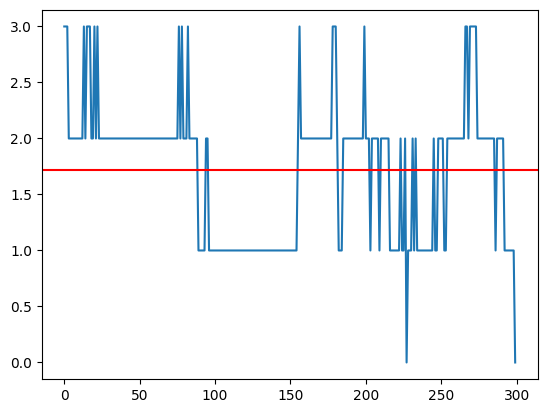

In [480]:
plt.plot(range(y_val2.shape[0]), in_index)
plt.axhline(xmin=0,xmax=y_val2.shape[0], y=np.mean(in_index),c='red');

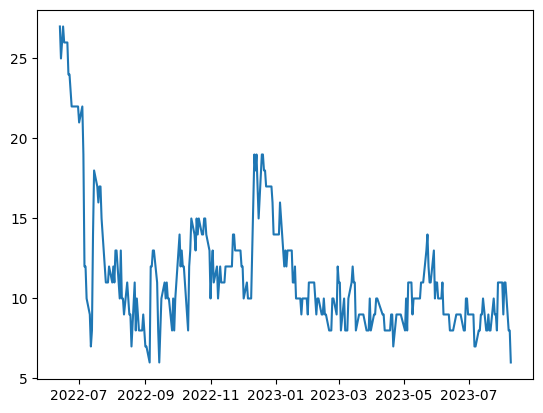

In [481]:
plt.plot(error_total.loc['ITX']);

In [482]:
error_total.mean(axis=1)[(error_total.mean(axis=1)<5)],error_total.std(axis=1)[(error_total.mean(axis=1)<5)]

(AMS_1    4.946488
 CABK     4.709030
 ELE_1    4.672241
 IAG      4.993311
 MAP_2    2.929766
 dtype: float64,
 AMS_1    2.766739
 CABK     6.129389
 ELE_1    3.463074
 IAG      3.230510
 MAP_2    2.219140
 dtype: float64)

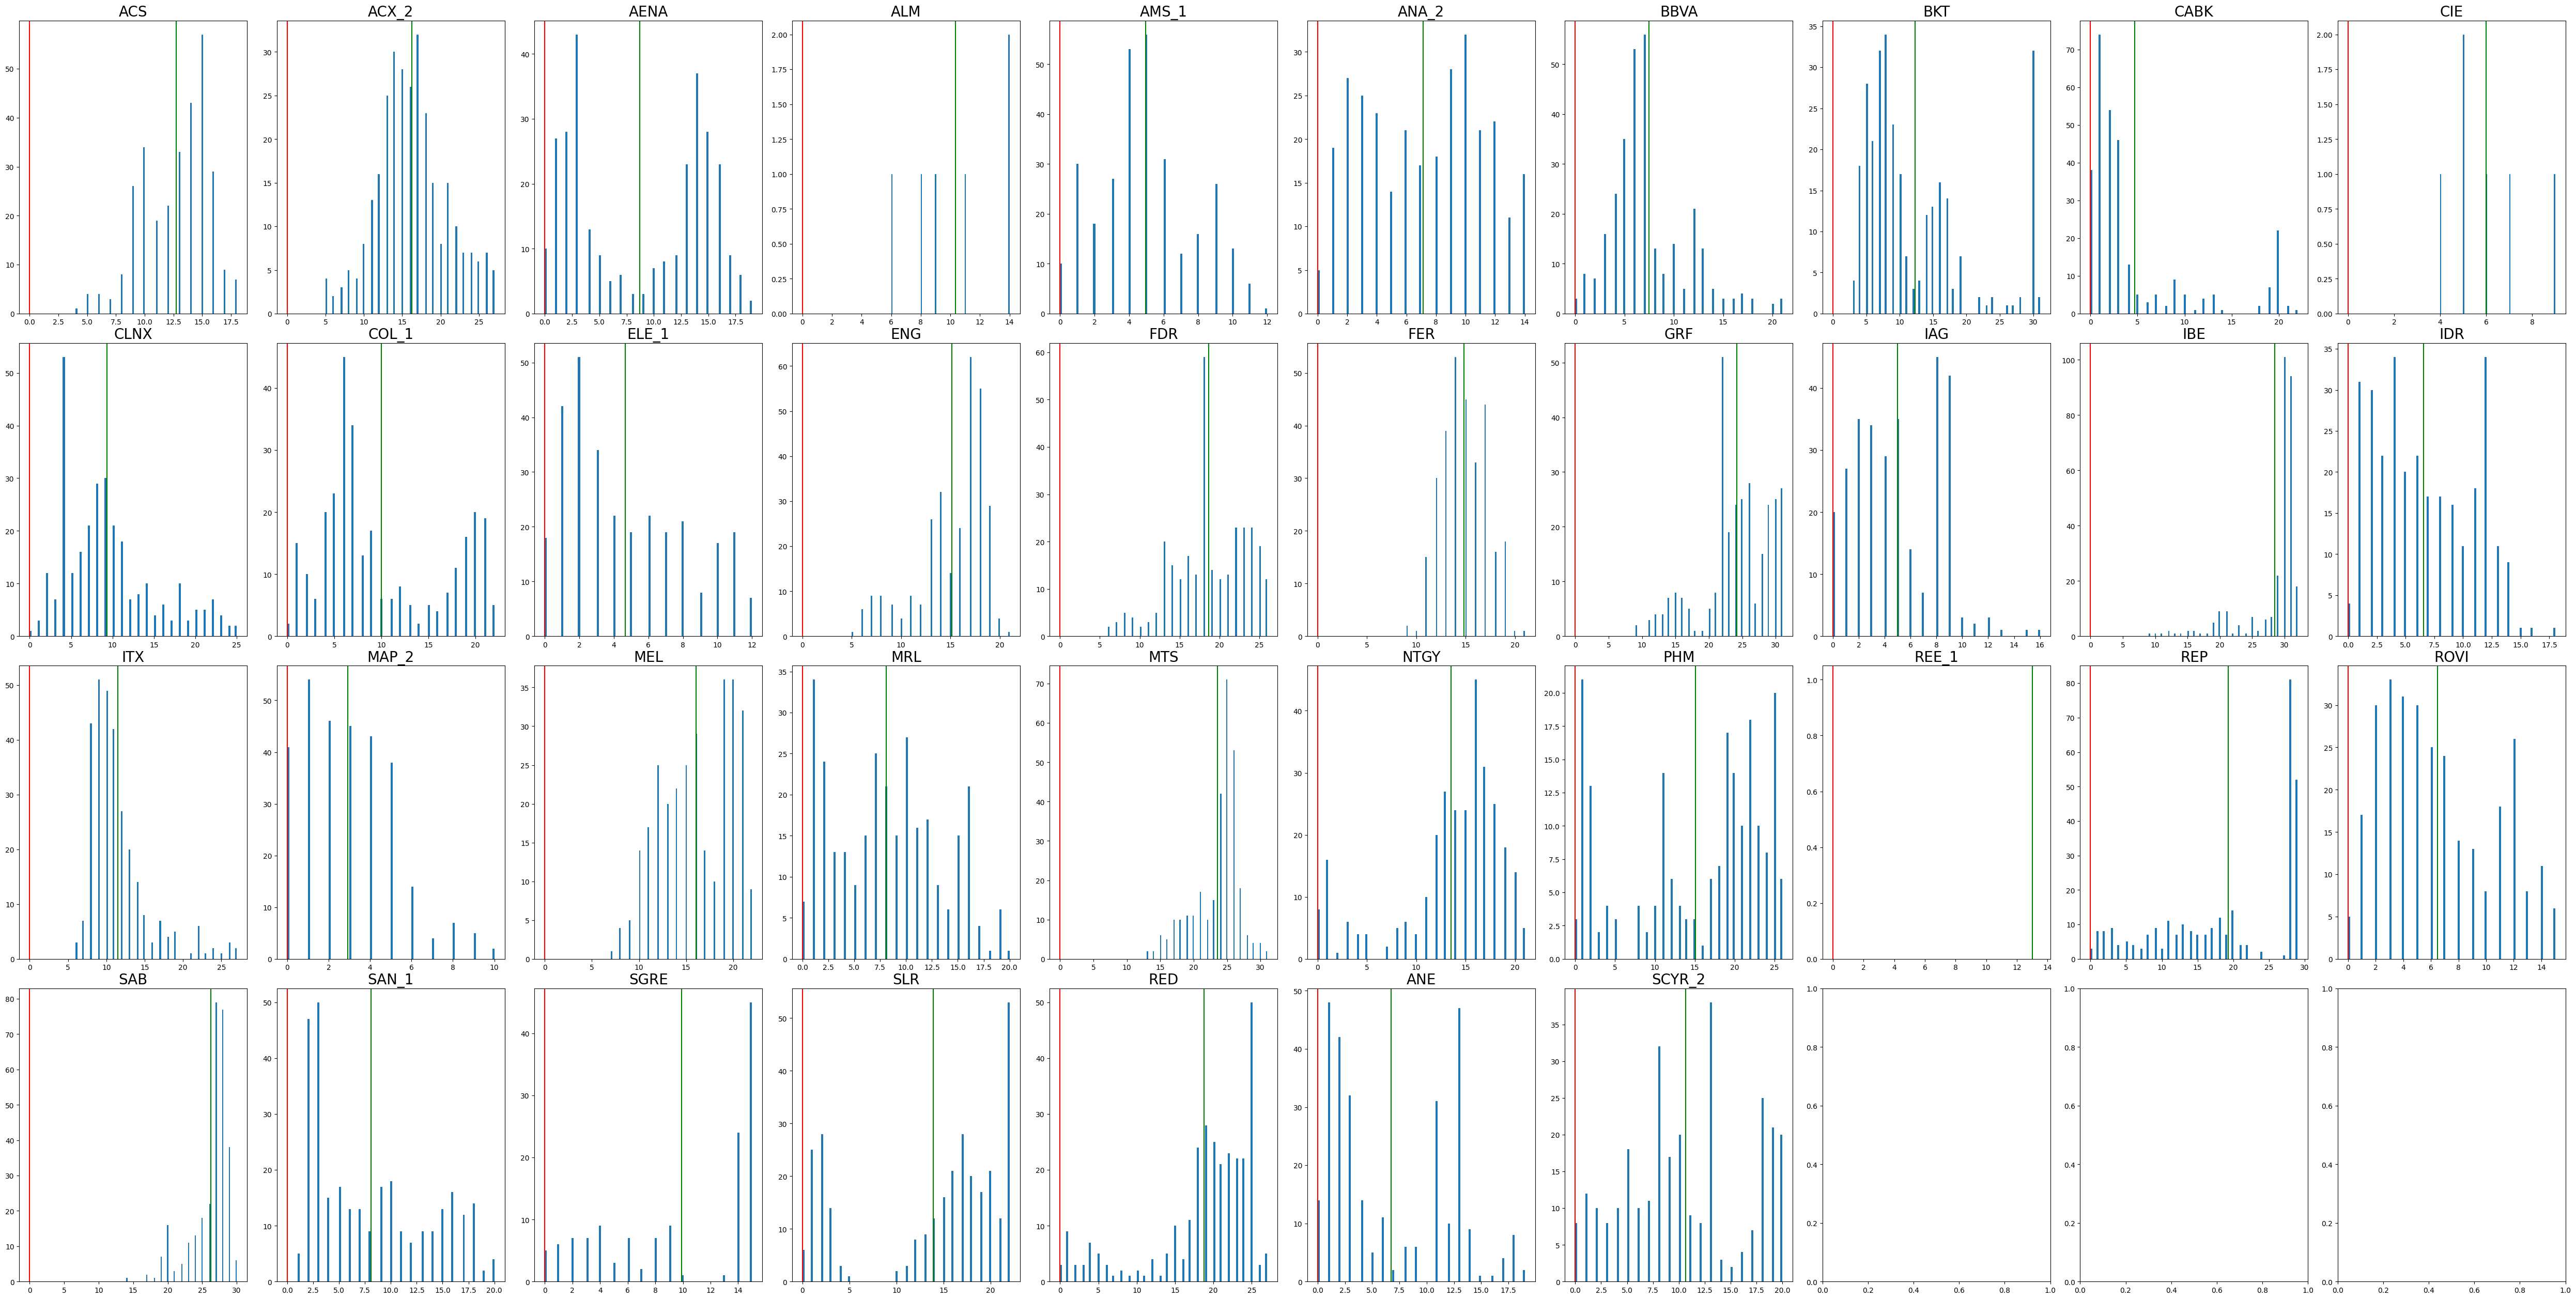

: 

In [483]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=math.ceil(len(error_total.index)/10), ncols=10, figsize=(50, 25))
fig.tight_layout(h_pad=2)
axs = axs.ravel()

for i in range(len(error_total.index)):

    axs[i].hist(error_total.loc[error_total.index[i]].dropna(),bins=100)
    axs[i].axvline(x=0,ymin=0,ymax=error_total.loc[error_total.index[i]].dropna().max()+1,c='red')
    axs[i].axvline(x=error_total.loc[error_total.index[i]].dropna().mean(),ymin=0,ymax=error_total.loc[error_total.index[i]].dropna().max()+1,c='green')
    axs[i].set_title(error_total.index[i],fontsize=20)